In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from keras.models import load_model

In [3]:
data = pd.read_csv('/content/drive/MyDrive/merged_data.csv')

In [4]:
model  = load_model('/content/drive/MyDrive/CNNLSTM_model')

In [5]:
data.head()

,Unnamed: 0,frame_number,pedestrian_ID,pos_x,pos_y,v_x,v_y,Constant_speed,Speed_as_magnitude,euclidean_distance_1_destination,euclidean_distance_2_destination,euclidean_distance_3_destination,euclidean_distance_4_destination,euclidean_distance_with_obstacles,euclidean_distance_neighbor,euclidean_distance_neighbor_group
0,0,780.0,1.0,8.46,3.59,1.671714,0.176292,12,9,28.547123,15.453889,17.143920,6.938212,5.905144,0.0,100.000000
1,1,810.0,1.0,11.73,4.32,1.644127,0.544391,19,12,31.768974,18.809644,19.783212,3.597770,2.549283,0.0,100.000000
2,2,810.0,2.0,12.09,5.75,-1.589052,-0.065971,16,13,32.087941,19.524408,19.620513,3.025126,2.218885,0.0,0.000000
3,3,840.0,2.0,9.57,6.24,-1.207725,0.115437,8,11,29.573747,17.299866,17.081161,5.576444,4.652295,0.0,2.423523
4,4,840.0,3.0,11.94,6.77,-1.028251,0.307482,13,13,31.949280,19.701188,19.182262,3.390577,2.321748,0.0,2.423523


In [6]:
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [7]:
data.head()

,frame_number,pedestrian_ID,pos_x,pos_y,v_x,v_y,Constant_speed,Speed_as_magnitude,euclidean_distance_1_destination,euclidean_distance_2_destination,euclidean_distance_3_destination,euclidean_distance_4_destination,euclidean_distance_with_obstacles,euclidean_distance_neighbor,euclidean_distance_neighbor_group
0,780.0,1.0,8.46,3.59,1.671714,0.176292,12,9,28.547123,15.453889,17.143920,6.938212,5.905144,0.0,100.000000
1,810.0,1.0,11.73,4.32,1.644127,0.544391,19,12,31.768974,18.809644,19.783212,3.597770,2.549283,0.0,100.000000
2,810.0,2.0,12.09,5.75,-1.589052,-0.065971,16,13,32.087941,19.524408,19.620513,3.025126,2.218885,0.0,0.000000
3,840.0,2.0,9.57,6.24,-1.207725,0.115437,8,11,29.573747,17.299866,17.081161,5.576444,4.652295,0.0,2.423523
4,840.0,3.0,11.94,6.77,-1.028251,0.307482,13,13,31.949280,19.701188,19.182262,3.390577,2.321748,0.0,2.423523


In [8]:
n_steps_in, n_steps_out = 8, 12 # number of input / number of outputs

In [9]:
# taking only posx and posy
def MakeInputOutput(dataset):
    # this method will make the base line model dataset which is basically x and y value itself.
    unique_ids = list(np.unique(dataset['pedestrian_ID']))
    X_values = dataset['pos_x']
    Y_values = dataset['pos_y']
    X_values = np.array(X_values).reshape((len(X_values), 1))
    Y_values = np.array(Y_values).reshape((len(Y_values), 1))
    stack = np.hstack((X_values,Y_values))
    return stack

In [10]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    # this function will make the sequence feature and output. in this method I am basically trying to convert time series into supervised structure where the input of first 8 sequence in time series would be the predicted 12 points
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [11]:
stack = MakeInputOutput(data) # taking only X and y value for this moment

In [12]:
X, y = split_sequences(stack, n_steps_in, n_steps_out)

In [13]:
def addNewFeature(X_old, column, dataset):
    # this function i have made in order to add more feature and correspondly train and predict the model
    new_X = [] # current feature
    All_feature = [] # whole feature dataset
    #for i in columns:
    new_x = np.array(dataset[column])
    if sum(np.isnan(new_x))>0:
        new_x = np.nan_to_num(new_x)
    # converting to the n_setpes in features
    for i in range(len(new_x)):
        end_idx = i + n_steps_in
        seqx = new_x[i:end_idx]
        new_X.append(seqx)
    for i in range(len(X_old)):
        x = new_X[i].reshape(n_steps_in,1)
        new_feature_array   = np.append(X_old[i],x,axis=1)
        All_feature.append(new_feature_array)
    print("INFO: allnew features has been added")
    return np.array(All_feature)

In [14]:
features = ['v_x', 'v_y',
       'euclidean_distance_1_destination', 'euclidean_distance_2_destination',
       'euclidean_distance_3_destination', 'euclidean_distance_4_destination',]

In [15]:
# here i am just adding all the features
for feature in features:
    new_X = addNewFeature(X,feature,data)
    X = new_X

INFO: allnew features has been added
INFO: allnew features has been added
INFO: allnew features has been added
INFO: allnew features has been added
INFO: allnew features has been added
INFO: allnew features has been added


In [16]:
X.shape

(270, 8, 8)

In [17]:
X = normalize(X.reshape(X.shape[0], X.shape[1]*X.shape[2])).reshape(X.shape[0], X.shape[1],X.shape[2])

In [18]:
preds = model.predict(X)

9/9 [==============================] - 1s 12ms/step


In [36]:
def load_models():
    model1 = load_model('/content/drive/MyDrive/CNNLSTM_model')
    model2 = load_model('/content/drive/MyDrive/GRU_model')
    model3 = load_model('/content/drive/MyDrive/MultiEndec_model')
    return model1, model2, model3

In [30]:
def predict(model, x,n_features):
    x = x.reshape(1,8,n_features)
    pred = model.predict(x)
    return pred

In [27]:
!pip install pytp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytp: filename=pytp-0.0.3-py3-none-any.whl size=6921 sha256=14be469797ad96266cce6d44cd3ae075d7257ce995402752aa47ea39b131c279
  Stored in directory: /root/.cache/pip/wheels/59/c9/73/596894a2f45ffbf123337af8bbfc1fb8b31c32d4b0aac7f875
Successfully built pytp


In [28]:
from pytp.utils.evaluate import get_ade,get_fde

In [75]:
from math import sqrt
def model_predictions(x, y,n_features):
    ade_scores = []
    fde_scores = []
    percentage_of_near_collision = []
    avg_ade, avg_fde = 0 , 0
    #making variable to count the ED < 0.1 
    near_collision = 0
    total_ade_scores = []
    total_fde_scores = []
    total_near_collision = []
    models  = load_models()
    #DL models
    for i in models:
        for j in range(len(x)):
            pred = predict(i, x[j], n_features)
            ade = get_ade(pred, y[j])
            new_y = y[j].reshape(1,pred.shape[1],pred.shape[2])
            print(new_y.shape, y.shape)
            ED = sqrt(np.diff(pred[0][0])**2 + np.diff(y[j][0])**2)
            if ED < 0.1:
              near_collision += 1
            #print(near_collision)
            fde = get_fde(pred, new_y)
            ade_scores.append(ade)
            fde_scores.append(fde)
            percentage_of_near_collision.append((near_collision/len(y))*100)
        #print(ade_scores)
        total_ade_scores.append(sum(ade_scores)/len(ade_scores))
        total_fde_scores.append(sum(fde_scores)/len(fde_scores))
        total_near_collision.append(sum(percentage_of_near_collision))
    
    return pd.DataFrame({'fde_score':total_fde_scores,'ade_score':total_ade_scores, 'near_collision':total_near_collision}, index=['CNN LSTM','GRU Model','Multiencoder'])
 

In [52]:
X[0]

array([[ 0.07475478,  0.03172218,  0.01477171,  0.00155776,  0.25224987,
         0.13655461,  0.15148818,  0.06130786],
       [ 0.10364936,  0.03817265,  0.01452794,  0.00481038,  0.28071899,
         0.16620695,  0.17480965,  0.03179084],
       [ 0.10683041,  0.05080851, -0.01404128, -0.00058294,  0.28353746,
         0.17252279,  0.173372  ,  0.0267308 ],
       [ 0.08456303,  0.05513828, -0.01067177,  0.00102003,  0.26132139,
         0.15286616,  0.15093362,  0.04927492],
       [ 0.10550497,  0.0598215 , -0.00908589,  0.00271699,  0.28231222,
         0.17408486,  0.1694995 ,  0.02996002],
       [ 0.063356  ,  0.05849606, -0.00995399,  0.00102854,  0.24014943,
         0.13464142,  0.1298292 ,  0.07077208],
       [ 0.08270742,  0.0605284 , -0.00989155, -0.00070962,  0.25955033,
         0.15313552,  0.14742226,  0.05206828],
       [ 0.00671556,  0.04418131,  0.014075  , -0.00096329,  0.18358528,
         0.07820382,  0.08866686,  0.12688735]])

In [60]:
np.diff(y[0][0])

array([3.63])

In [59]:
4.23 - 0.6

3.6300000000000003

In [76]:
score_df = model_predictions(X, y, X.shape[-1])

1/1 [==============================] - 0s 225ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 23ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 19ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 22ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 18ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 30ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 20ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 21ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 24ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 22ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 21ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 27ms/step
(1, 12, 2) (270, 12, 2)
1/1 [==============================] - 0s 26ms/step
(1, 12, 2) (270, 12, 2)
1/1 [======

In [77]:
score_df

,fde_score,ade_score,near_collision
CNN LSTM,4.003197,3.906576,0.0
GRU Model,4.021127,3.896170,0.0
Multiencoder,3.971043,3.818437,0.0


In [79]:
score_df.sort_values(by = ['fde_score', 'ade_score'], ascending = [True, True])

,fde_score,ade_score,near_collision
Multiencoder,3.971043,3.818437,0.0
CNN LSTM,4.003197,3.906576,0.0
GRU Model,4.021127,3.896170,0.0


Task 6 

In [152]:
def plot(model, X_feature, y_actual, figure_name):
    # checking which model it is   
    pred = predict(model, X_feature, X_feature.shape[-1])
    plt.scatter(y_actual[:, 0], y_actual[:, 1])
    plt.title("Actual Y values")
    plt.xlabel('Actual posx values ')
    plt.ylabel('Actual posy values')
    plt.show()
    try:
        plt.savefig(f'{model.name}_actual_{figure_name}.png')
    except:
        print('some error is coming while saving')
    
    plt.scatter(pred[:, 0], pred[:, 1])
    plt.title("Predicted Y values")
    plt.xlabel('Predicted posx values ')
    plt.ylabel('Predicted posy values')
    plt.show()
    try:
        plt.savefig(f'{model.name}_predicted_{figure_name}.png')
    except:
        print('some error is coming while saving')
   

In [153]:
def MakePlots(x,y_actual,figure_name):
    models  = load_models()
    #DL models
    for i in models:
        plt = plot(i, x, y_actual,figure_name)
        #Saving the plots

# Visualizing whole data values first.

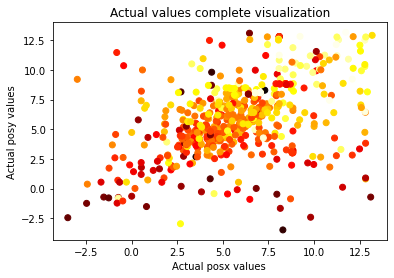

In [170]:
plt.scatter(y[:, 0], y[:, 1], c=y[:, 2], cmap='hot')
plt.title("Actual values complete visualization")
plt.xlabel('Actual posx values ')
plt.ylabel('Actual posy values')
plt.show()

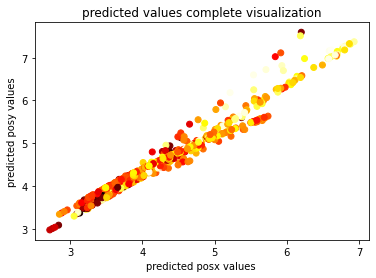

In [171]:
plt.scatter(preds[:, 0], preds[:, 1], c=y[:, 2], cmap='hot')
plt.title("predicted values complete visualization")
plt.xlabel('predicted posx values ')
plt.ylabel('predicted posy values')
plt.show()

# Visualizing some values one by one 

1/1 [==============================] - 0s 224ms/step


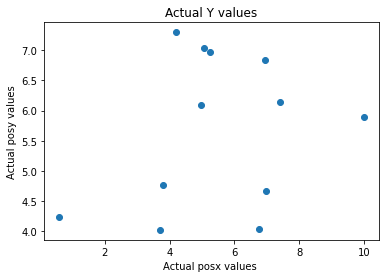

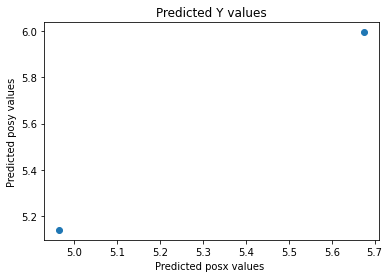

1/1 [==============================] - 2s 2s/step


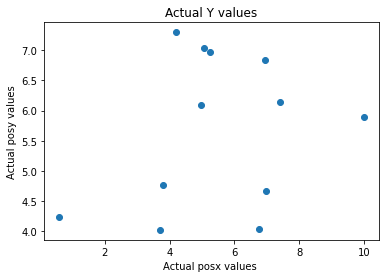

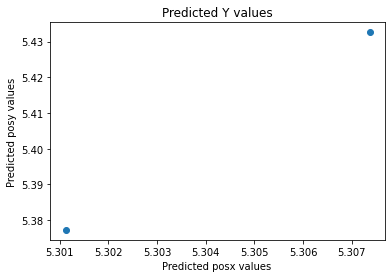

1/1 [==============================] - 0s 317ms/step


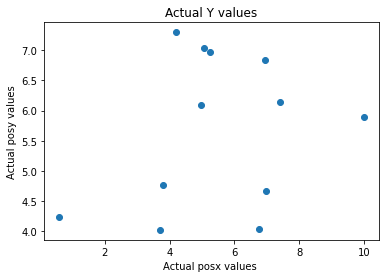

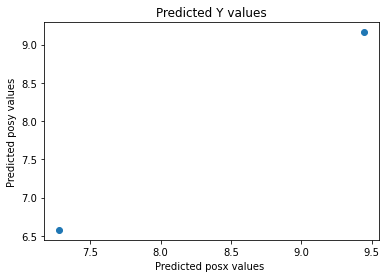

<Figure size 432x288 with 0 Axes>

In [154]:
MakePlots(X[0],y[0],figure_name='first_plot')

1/1 [==============================] - 0s 269ms/step


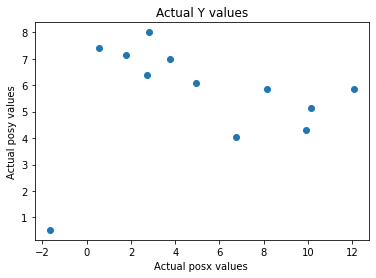

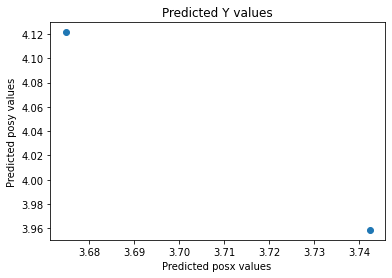

1/1 [==============================] - 3s 3s/step


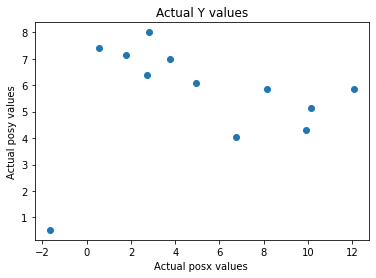

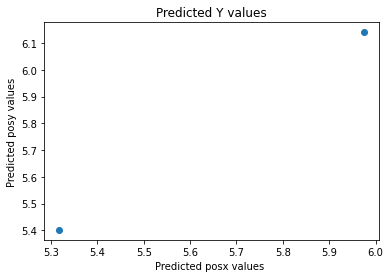

1/1 [==============================] - 0s 460ms/step


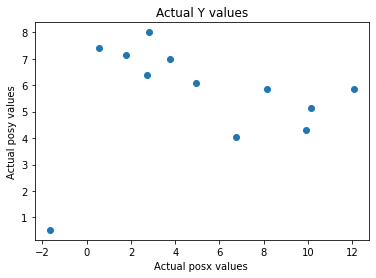

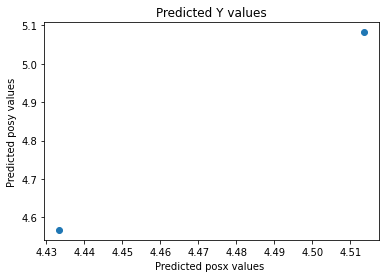

<Figure size 432x288 with 0 Axes>

In [155]:
MakePlots(X[10],y[10],figure_name='second_plot')

1/1 [==============================] - 0s 236ms/step


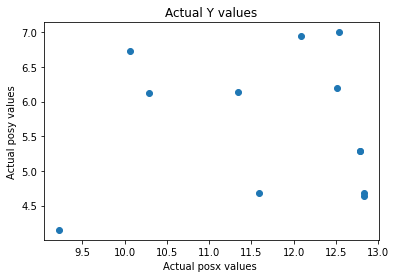

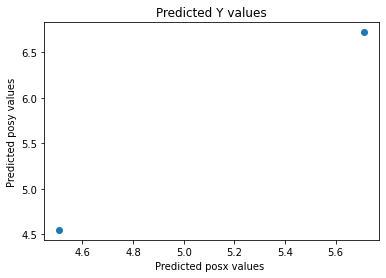

1/1 [==============================] - 1s 1s/step


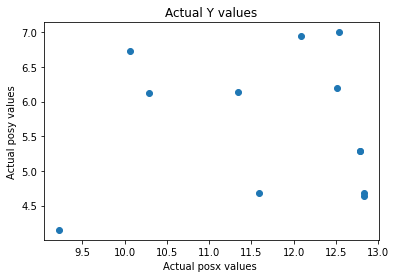

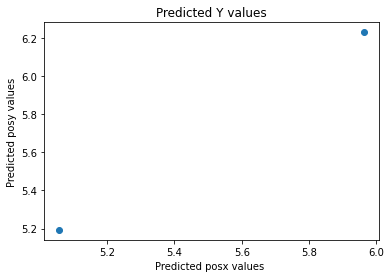

1/1 [==============================] - 0s 304ms/step


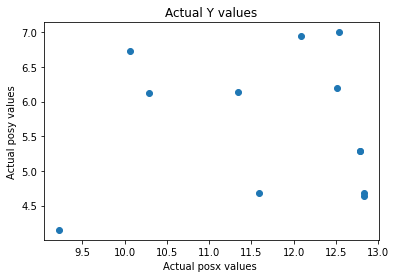

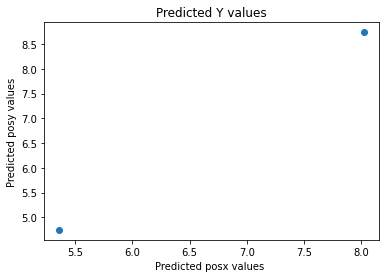

<Figure size 432x288 with 0 Axes>

In [156]:
MakePlots(X[31],y[31],figure_name='third_plot')

1/1 [==============================] - 0s 216ms/step


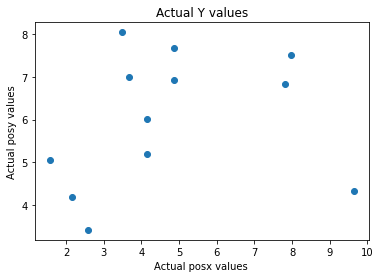

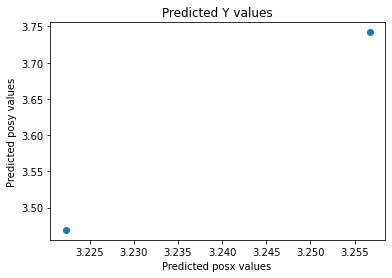

1/1 [==============================] - 1s 1s/step


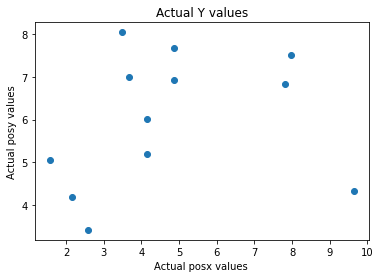

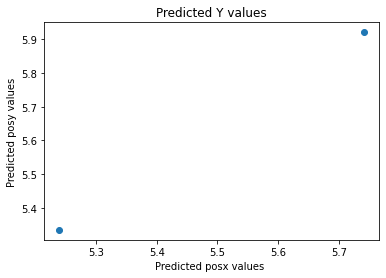

1/1 [==============================] - 0s 335ms/step


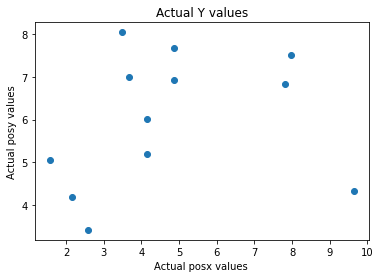

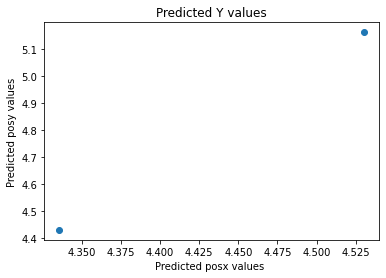

<Figure size 432x288 with 0 Axes>

In [157]:
MakePlots(X[67],y[67],figure_name='fourth_plot')